In [283]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [284]:
import tensorflow as tf
from tensorflow.keras import models,layers, regularizers
import matplotlib.pyplot as plt
import numpy as np
import math

from tensorflow.keras.callbacks import EarlyStopping

# **1. XỬ LÝ DATASET**

# **#. LOAD DATASET**

In [285]:
BATCH_SIZE = 32
IMAGE_SIZE = 255
CHANNEL = 3

In [286]:
# load dataset và chia batch. Tương tự ((imgs, labels), ...)
ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory='/content/drive/MyDrive/Colab Notebooks/crop-disease-classification/dataset/Potato',
  seed=123,       # kết quả giống nhau mỗi lần xáo trộn
  shuffle = True,
  image_size=(IMAGE_SIZE,IMAGE_SIZE),  # 255x255
  batch_size = BATCH_SIZE,
)

ds

Found 1510 files belonging to 3 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [287]:
total_batch = len(ds)  #tổng số batch: 1510/50
total_batch

48

In [288]:
first_batch = ds.take(1)
len(ds.take(1))

1

1 epoch = tổng số batch = n/batch_size

In [289]:
for images_tf, labels_tf in ds.take(1):
    print("images_tf Shape:", images_tf.shape)  # 4D
    print("labels_tf Shape:", labels_tf.shape)  # 1D
    print("image shape:", images_tf[0].shape)  # 3D
    print("Label numpy:", labels_tf.numpy) # labels_tf.numpy()

images_tf Shape: (32, 255, 255, 3)
labels_tf Shape: (32,)
image shape: (255, 255, 3)
Label numpy: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 1, 1, 0, 2, 2, 2, 2, 0, 2, 1, 1, 0, 1, 2, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 2, 2, 1, 2, 2, 0], dtype=int32)>>


In [290]:
# 3 nhãn
labels = ds.class_names
labels

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

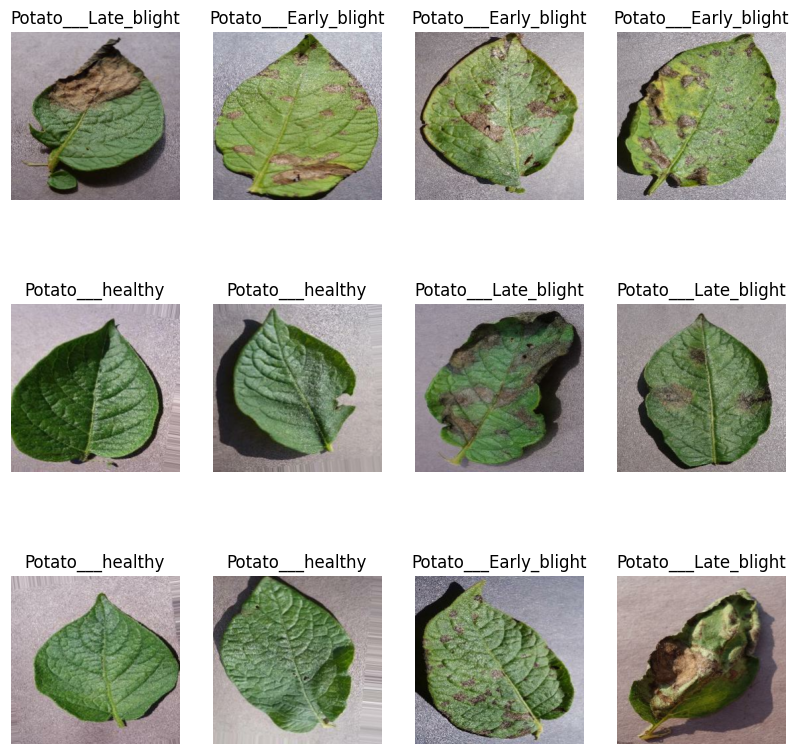

In [291]:
def display_imgs():
  plt.figure(figsize=(10, 10)) #10 inch × 10 inch

  for images_tf, labels_tf in ds.take(1):
      for item in range(12):
          ax = plt.subplot(3, 4, item + 1) # vẽ trục: 3x4, bắt đầu từ ô thứ 1
          plt.imshow(images_tf[item].numpy().astype("uint8"))
          plt.title(labels[labels_tf[item]])
          plt.axis("off")

display_imgs()

# **#. ENCODING**

In [292]:
# one-hot encoding
def encode_one_hot(imgs_tf, labels_tf):
    return (imgs_tf, tf.one_hot(labels_tf, len(ds.class_names)))

ds = ds.map(encode_one_hot)
ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [293]:
for images_tf, labels_tf in ds.take(1):
    print("Images shape:", images_tf.shape)   # 4D
    print("Labels shape:", labels_tf[:5])   # 2D: (row, column)

Images shape: (32, 255, 255, 3)
Labels shape: tf.Tensor(
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]], shape=(5, 3), dtype=float32)


# **#. CHIA DỮ LIỆU**

In [294]:
def split_dataset (ds, train_split=0.8, val_split=0.15, test_split=0.05, shuffle=True, shuffle_size=10000):
    assert abs(train_split + val_split + test_split - 1.0) < 1e-6

    if shuffle:
      ds = ds.shuffle(shuffle_size, seed=123)

    ds = ds.cache()   # load vào đệm

    train_length = math.floor(len(ds) * train_split)
    val_length = math.floor(len(ds) * val_split)
    test_length = math.floor(len(ds) * test_split)

    ds = ds.enumerate()

    train_ds = (ds.filter(lambda i, _: i < train_length).map(lambda _, batch: batch))
    val_ds = (ds.filter(lambda i, _: train_length <= i < train_length + val_length).map(lambda _, batch: batch))
    test_ds = (ds.filter(lambda i, _: train_length + val_length <= i).map(lambda _, batch: batch))

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(ds)


# **#. RESIZE + SCALING**

In [295]:
resize_and_rescale = tf.keras.Sequential([   # thêm lớp trực tiếp layer vào mô hình
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),  # chuẩn hóa giá trị pixel ([0, 255]) về [0, 1]
])

# train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
# val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
# test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

# **#. TĂNG CƯỜNG DỮ LIỆU**
-chỉ tăng cường dữ liệu cho tập train

In [296]:
data_augmentation = tf.keras.Sequential([   # thêm trực tiếp layer
    layers.RandomFlip("horizontal_and_vertical"), # lật
    layers.RandomRotation(0.2), # xoay
])

# train_ds = train_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y)  # chỉ khi train
# )

# **#. CACHE, SHUFFLE, PREFETCH**

In [297]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# **2. MODEL**

In [298]:
# kiến trúc model

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNEL) # cấu trúc 1 image
model = models.Sequential([
    layers.Input(shape=input_shape),

    # 32 kernel
    layers.Conv2D(32, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    # fully-connected, 256 notron
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    # layers.Dropout(0.4),  # Dropout cho lớp fully connected

    # output-layer: softmax phân loại nhiều lớp
    layers.Dense(len(labels), activation='softmax')  # 3 notron cho 3 lớp
])

model.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 253, 253, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 253, 253, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 253, 253, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 124, 124, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 124, 124, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,666,819 (25.43 MB)

 Trainable params: 6,665,603 (25.43 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [299]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), # CategoricalCrossentropy cho one-hot label, from_logits=False vì đã sd softmax
    metrics=['accuracy']  # tỷ lệ dự đoán đúng so với tổng số dự đoán
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# fit và train
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - accuracy: 0.8212 - loss: 0.5608 - val_accuracy: 0.3482 - val_loss: 81.3950
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9767 - loss: 0.0785 - val_accuracy: 0.3482 - val_loss: 38.8357
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9774 - loss: 0.0504 - val_accuracy: 0.4018 - val_loss: 11.3798
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9909 - loss: 0.0322 - val_accuracy: 0.3482 - val_loss: 21.5730
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9949 - loss: 0.0222 - val_accuracy: 0.8661 - val_loss: 0.5753
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.9554 - val_loss: 0.1165
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.9965 - loss: 0.0129 - val_accuracy: 0.8080 - val_loss: 1.0115
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accu

# **3. ĐÁNH GIÁ MODEL**

In [300]:
scores = model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9740 - loss: 0.0371


In [301]:
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 100, 'steps': None}
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [302]:
history.history['loss'][:5]

[0.3575165569782257,
 0.08780617266893387,
 0.05426277965307236,
 0.03635213524103165,
 0.019401010125875473]

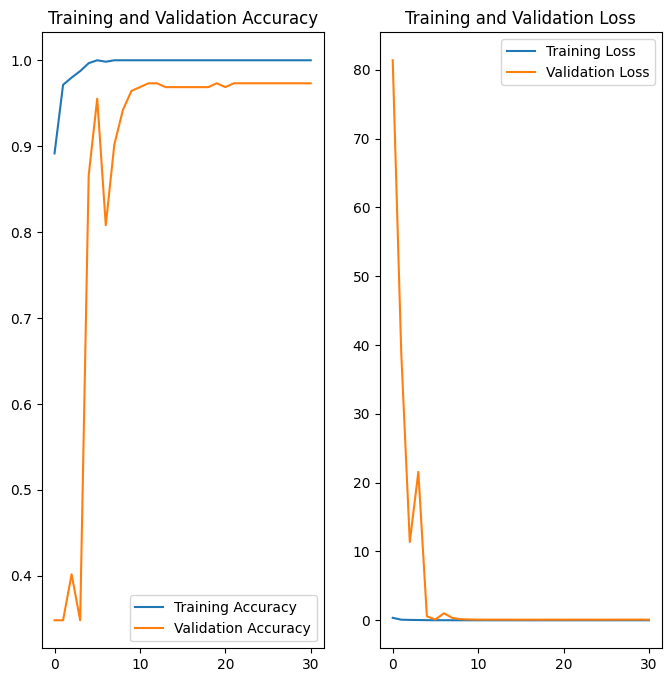

In [303]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

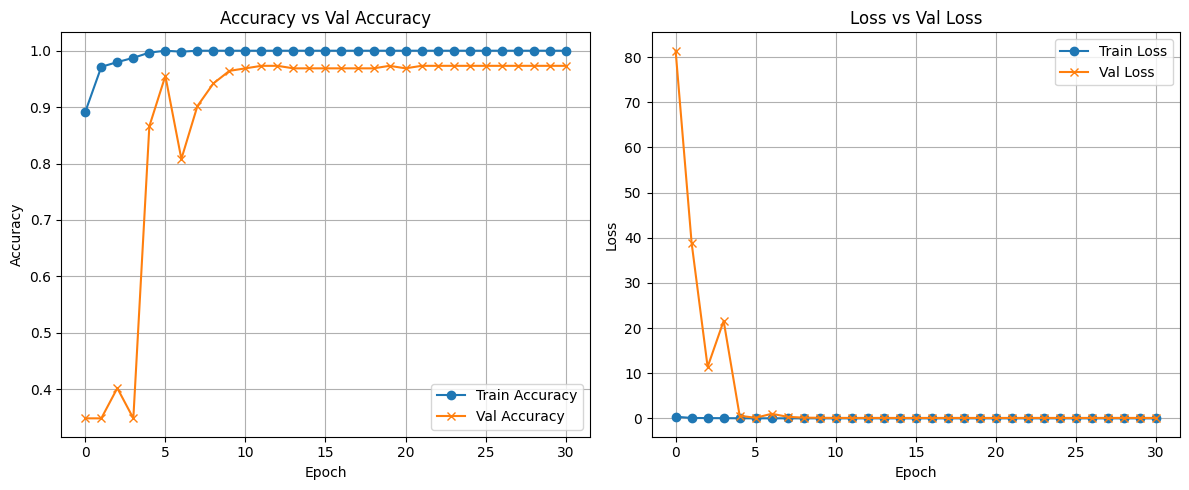

In [304]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.title('Accuracy vs Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Loss vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [305]:
model.save("/content/drive/MyDrive/Colab Notebooks/crop-disease-classification/model/model.h5")

# **4. DỰ ĐOÁN**

In [306]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/crop-disease-classification/model/model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


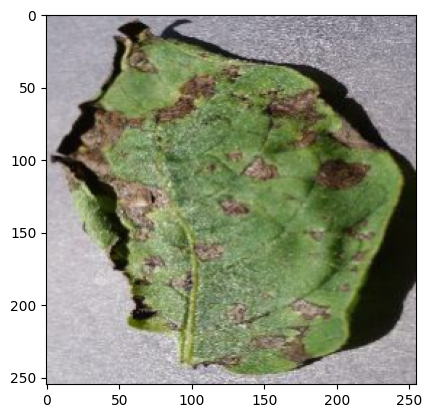

In [307]:
# test
def test_predict():
  for images_tf, labels_tf in test_ds.take(1):
    # F_predict = resize_and_rescale(images_tf)

    y_predict = model.predict(images_tf)    # 2D
    print("actual label:", labels[np.argmax(labels_tf[4])])
    print("predicted label:",labels[np.argmax(y_predict[4])])

    plt.imshow(images_tf[4].numpy().astype("uint8"))

test_predict()

In [308]:
def display(y_predict):
    for i in range(9):
        print(y_predict[[i]])

        actual_label = labels[np.argmax(labels_tf[i])]

        predicted_label = labels[np.argmax(y_predict[i])]  # lấy chỉ mục của giá trị lớn nhất

        predicted_score = round(np.max(y_predict[i]) * 100, 2) # chuyển về %

        ax = plt.subplot(3, 3, i + 1)
        plt.title(f"Actual: {actual_label},\n Predicted: {predicted_label}.\n predicted_score: {predicted_score}%")
        plt.axis("off")
        plt.imshow(images_tf[i].numpy().astype("uint8"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
[[1.9422497e-04 2.9567204e-04 9.9951005e-01]]
[[8.2692355e-07 4.4373141e-07 9.9999869e-01]]
[[9.9973756e-01 2.4573109e-04 1.6696618e-05]]
[[1.1879795e-05 9.9998665e-01 1.3878539e-06]]
[[9.9999940e-01 6.0333588e-07 2.1172404e-08]]
[[1.0000000e+00 3.8665946e-09 9.9660280e-09]]
[[9.999870e-01 9.030730e-06 3.952826e-06]]
[[1.000000e+00 8.397105e-09 7.436145e-09]]
[[9.9999177e-01 8.5627016e-07 7.3547985e-06]]


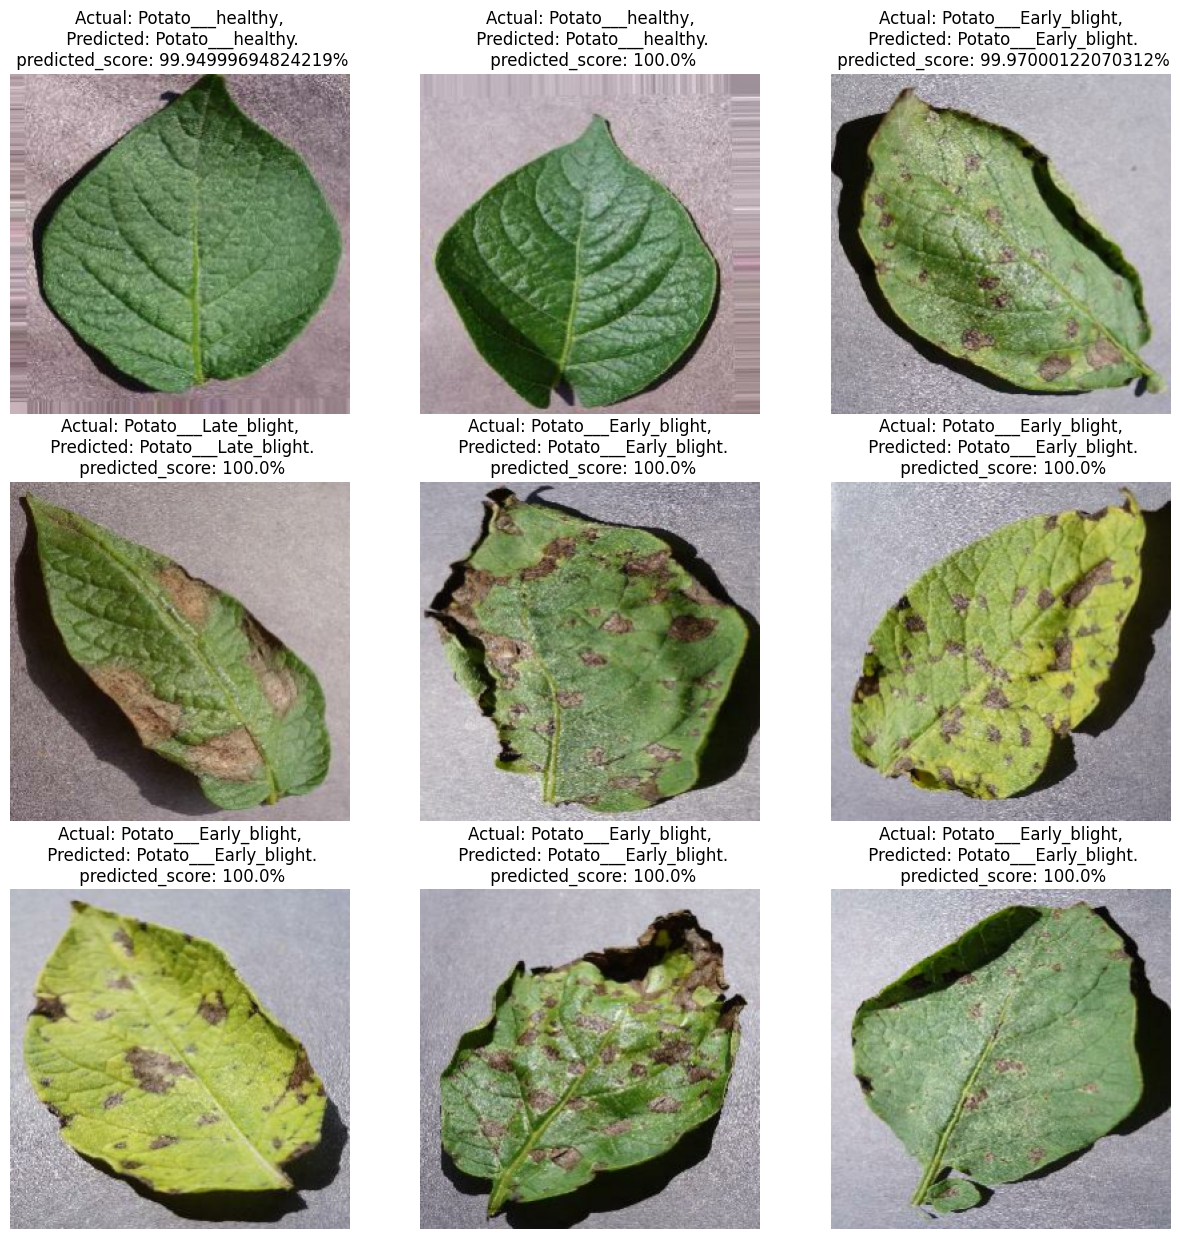

In [309]:
plt.figure(figsize=(15, 15))

for images_tf, labels_tf in test_ds.take(1):
    # F_predict = resize_and_rescale(images_tf)
    y_predict = model.predict(images_tf) # return 2D
    display(y_predict)